In [1]:
#load dataset

#Impoart Datasets
import pandas as pd
indiv=pd.read_csv(r'C:\Users\madlin\Desktop\les notes de madeline\mademoiselle madeline stuff boooom\DS\ML\CS655 Individual Dataset.csv')

#data preparation
#Scale some of the attributes
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Scale the key, loudness, tempo attributes using min-max scaling in individual dataset
key_scaler = MinMaxScaler()
scaled_key = key_scaler.fit_transform(indiv[['key']])

loudness_scaler = MinMaxScaler()
scaled_loudness = loudness_scaler.fit_transform(indiv[['loudness']])

tempo_scaler = MinMaxScaler()
scaled_tempo = tempo_scaler.fit_transform(indiv[['tempo']])

indiv['scaled_key']=scaled_key
indiv['scaled_loudness']=scaled_loudness
indiv['scaled_tempo']=scaled_tempo

#Train/Validation/Test Split
from sklearn.model_selection import train_test_split

# Split the indiv dataset into training and test sets (80% training data, 20% test data)
indiv_train, indiv_test, msPlayed_train, msPlayed_test = train_test_split(indiv,
                                                                          indiv['msPlayed'], 
                                                                          test_size=0.2, 
                                                                          random_state=69)

# Split the training data further into training and validation sets (80% training data, 20% validation data)
indiv_train, indiv_val, msPlayed_train, msPlayed_val = train_test_split(indiv_train, 
                                                                          msPlayed_train, 
                                                                          test_size=0.2, 
                                                                          random_state=69)

In [2]:
#Data Modeling
#SVR

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Select the columns to use for training the model
cols_to_use = ['danceability', 'energy', 'scaled_key', 'scaled_loudness', 'mode', 'speechiness', 
               'acousticness', 'instrumentalness', 'liveness', 'valence', 'scaled_tempo']

# Create dataframes for training, validation and test sets with only the selected columns
indiv_train_subset = indiv_train[cols_to_use]
indiv_val_subset = indiv_val[cols_to_use]
indiv_test_subset = indiv_test[cols_to_use]

# Separate the target variable from the training, validation and test sets
y_train = msPlayed_train
y_val = msPlayed_val
y_test = msPlayed_test

# Define the parameter grid to search
param_grid = {'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 1]}

# Create a grid search object with cross-validation
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(indiv_train_subset, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_svr = grid_search.best_estimator_

# Predict the streaming time for the test set using the best model
y_pred = best_svr.predict(indiv_test_subset)

# Evaluate the model performance using RMSE and R-squared
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE: {:.2f}".format(rmse))
print("R-squared: {:.2f}".format(r2))

Best hyperparameters: {'C': 100, 'epsilon': 0.01, 'gamma': 1}
RMSE: 5513095.10
R-squared: -0.17


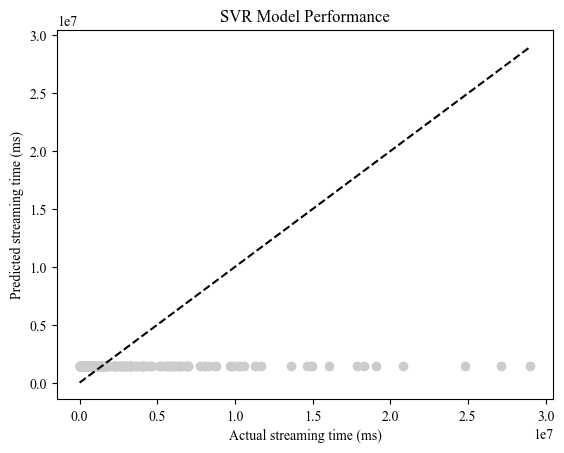

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the font as the font
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

# Predict the streaming time for the test set using the best model
y_pred = best_svr.predict(indiv_test_subset)

# Create a scatter plot of the actual vs predicted values
plt.scatter(y_test, y_pred, color='#CCCCCC') # set color to light grey
plt.xlabel("Actual streaming time (ms)")
plt.ylabel("Predicted streaming time (ms)")
plt.title("SVR Model Performance")

# Add a diagonal line representing perfect prediction
plt.plot([0, max(y_test)], [0, max(y_test)], 'k--')

plt.show()

In [7]:
#Data Modeling
#FNN

!pip install keras
!pip install tensorflow
!pip install keras-tuner

# Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
from kerastuner.tuners import RandomSearch
import numpy as np

# Select the columns to use for training the model
cols_to_use = ['danceability', 'energy', 'scaled_key', 'scaled_loudness', 'mode', 'speechiness', 
               'acousticness', 'instrumentalness', 'liveness', 'valence', 'scaled_tempo']

# Create dataframes for training, validation and test sets with only the selected columns
indiv_train_subset = indiv_train[cols_to_use]
indiv_val_subset = indiv_val[cols_to_use]
indiv_test_subset = indiv_test[cols_to_use]

# Separate the target variable from the training, validation and test sets
y_train = msPlayed_train
y_val = msPlayed_val
y_test = msPlayed_test


# Define the model architecture
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                           input_shape=(len(cols_to_use),),
                           activation=hp.Choice('dense_activation_1', values=['relu', 'tanh', 'sigmoid'])))
    model.add(layers.Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                           activation=hp.Choice('dense_activation_2', values=['relu', 'tanh', 'sigmoid'])))
    model.add(layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    return model


# Define the hyperparameter search space
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=3,
    directory='madelineL',
    project_name='madelineLpro')

# Search for the best hyperparameters
tuner.search(indiv_train_subset, y_train, validation_data=(indiv_val_subset, y_val), epochs=100, batch_size=32)

# Get the best model from the search
best_fnn = tuner.get_best_models(num_models=1)[0]

# Evaluate the model performance using RMSE and R-squared
y_pred = best_fnn.predict(indiv_test_subset)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print("RMSE: {:.2f}".format(rmse))
print("R-squared: {:.2f}".format(r2))

  Using cached keras_tuner-1.3.4-py3-none-any.whl (172 kB)
INFO:tensorflow:Reloading Tuner from madelineL\madelineLpro\tuner0.json


INFO:tensorflow:Oracle triggered exit


C:\Users\madlin\AppData\Local\Temp\ipykernel_24596\1880622572.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


6/6 [==============================] - 0s 965us/step
RMSE: 5253166.92
R-squared: -0.07


In [8]:
best_fnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               2304      
                                                                 
 dense_1 (Dense)             (None, 64)                12352     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________


In [9]:
import matplotlib.pyplot as plt

# Predict the streaming time for the test set using the best model
y_pred = best_fnn.predict(indiv_test_subset)

# Create a scatter plot of the actual vs predicted values with grey dots

plt.xlabel("Actual streaming time (ms)")
plt.ylabel("Predicted streaming time (ms)")
plt.scatter(y_test, y_pred, color='#CCCCCC')
plt.title("FNN Model Performance")

# Add a diagonal line representing perfect prediction
plt.plot([0, max(y_test)], [0, max(y_test)], 'k--')

plt.show()

6/6 [==============================] - 0s 1ms/step


In [10]:
min_msPlayed = indiv['msPlayed'].min()
max_msPlayed = indiv['msPlayed'].max()
range_msPlayed = max_msPlayed - min_msPlayed

print("Range of msPlayed: ", range_msPlayed)

Range of msPlayed:  135097816


In [11]:
#Further Analysis
#fit SVR and FNN model in Global Weekly Top 100 Songs dataset

gt100=pd.read_csv(r'C:\Users\madlin\Desktop\les notes de madeline\mademoiselle madeline stuff boooom\DS\ML\CS655 Global Weekly Top 100 Songs.csv')

#data preparation
#Scale some of the attributes
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Scale the key, loudness, tempo attributes using min-max scaling in individual dataset
key_scaler = MinMaxScaler()
scaled_key = key_scaler.fit_transform(gt100[['key']])

loudness_scaler = MinMaxScaler()
scaled_loudness = loudness_scaler.fit_transform(gt100[['loudness']])

tempo_scaler = MinMaxScaler()
scaled_tempo = tempo_scaler.fit_transform(gt100[['tempo']])

gt100['scaled_key']=scaled_key
gt100['scaled_loudness']=scaled_loudness
gt100['scaled_tempo']=scaled_tempo

# Extract the same audio features used in the individual dataset
gt100_features = gt100[['danceability', 'energy', 'scaled_key', 'scaled_loudness', 'mode', 'speechiness', 'acousticness',
                             'instrumentalness', 'liveness', 'valence', 'scaled_tempo']]

# Use the SVR model to predict msPlayed for each song
svr_pred_msPlayed = best_svr.predict(gt100_features)

# Use the FNN model to predict msPlayed for each song
fnn_pred_msPlayed = best_fnn.predict(gt100_features)

# Add two pred_msPlayed columns to the global dataset
gt100['svr_pred_msPlayed'] = svr_pred_msPlayed
gt100['fnn_pred_msPlayed'] = fnn_pred_msPlayed

# Sort the dataset by pred_msPlayed and choose the top 20 songs
svr_top_20_songs = gt100.sort_values('svr_pred_msPlayed', ascending=False).head(20)
fnn_top_20_songs = gt100.sort_values('fnn_pred_msPlayed', ascending=False).head(20)

print(svr_top_20_songs[['artist', 'track']])
print('')
print(fnn_top_20_songs[['artist', 'track']])

4/4 [==============================] - 0s 1ms/step
                               artist  \
4            David Guetta, Bebe Rexha   
43                    Imagine Dragons   
65                        LE SSERAFIM   
53                       Yandel, Feid   
30                        Chris Brown   
55      Rauw Alejandro, Lyanno, Brray   
70                         Fujii Kaze   
29                           NewJeans   
25          Oliver Tree, Robin Schulz   
37                          Lady Gaga   
57                            Quevedo   
10                           NewJeans   
98                    RAYE, 070 Shake   
77                           NewJeans   
42  Metro Boomin, Future, Chris Brown   
28                          Bad Bunny   
3                        Harry Styles   
24                             Miguel   
15                   Drake, 21 Savage   
85                          Lil Nas X   

                                                track  
4                              